<a href="https://colab.research.google.com/github/ajayrfhp/LearningDeepLearning/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install d2l

In [ ]:
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import torchvision.transforms as transforms

device_type = 'cpu'
if torch.cuda.is_available():
  device_type = 'cuda'

device = torch.device(device_type)
device

VGG network
- Principled way of building neural nets
- Use only 3*3 convs and stack multiple of them together.
- Vgg 11 architecture
  - conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

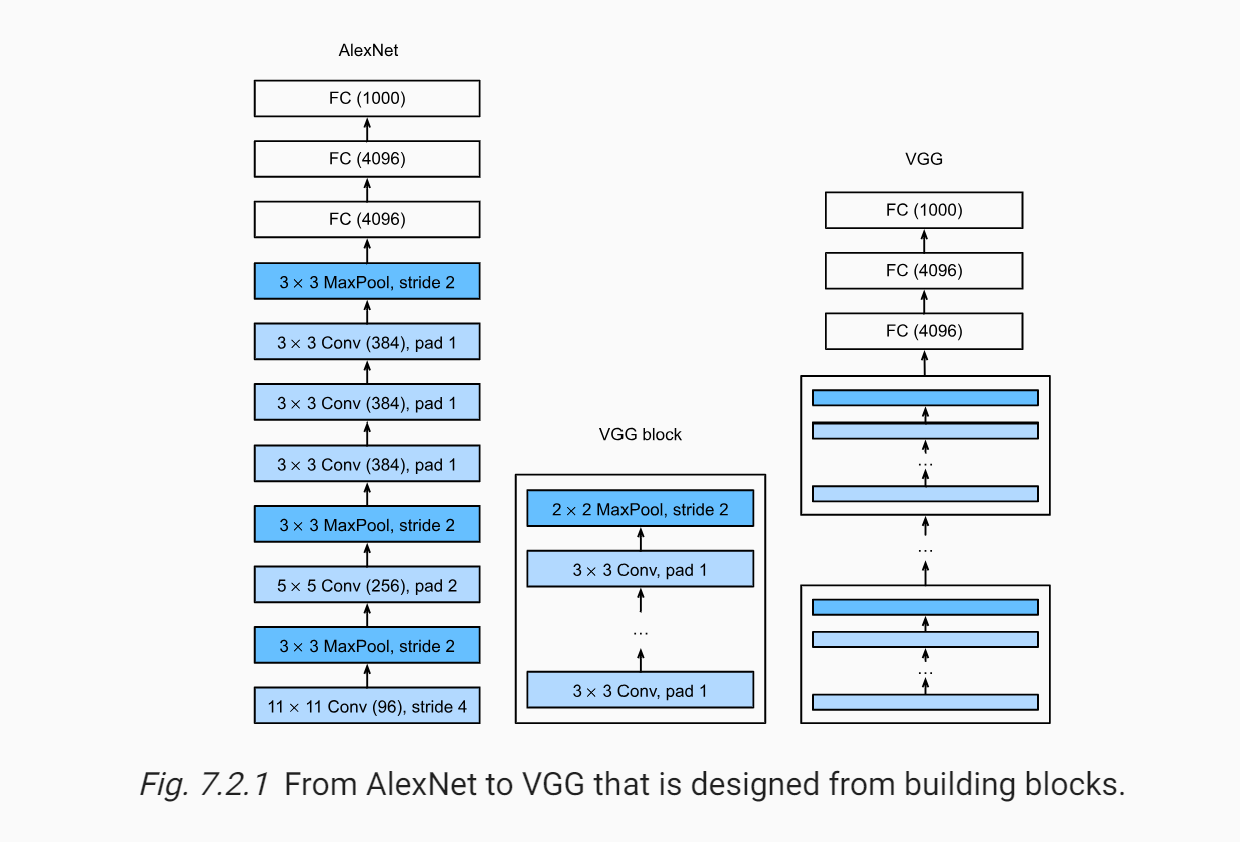

In [ ]:
def vgg_block(num_layers, in_channels, out_channels, drop_out=0.5, ratio=4):
  layers = []
  out_channels = int(out_channels // ratio)
  in_channels = int(in_channels // ratio)
  for i in range(num_layers):
    conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
    relu = nn.ReLU()
    drop_out = nn.Dropout(0.5)
    layers.extend([conv, relu, drop_out])
    in_channels = out_channels
  pooling = nn.MaxPool2d(kernel_size=2, stride=2)
  layers.append(pooling)
  return nn.Sequential(*layers)

In [ ]:
b1 = vgg_block(1, 1, 1)

In [ ]:
def init_cnn(module):
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        nn.init.xavier_uniform_(module.weight)

class VGG11(d2l.Classifier):
  def __init__(self, num_classes=10, lr=0.1):
    super().__init__()
    self.lr = lr
    # ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
    self.vgg = vgg_block(1, 4, 64) + vgg_block(1, 64, 128) + vgg_block(2, 128, 256) + vgg_block(2, 256, 512) + vgg_block(2, 512, 512)
    self.fc = nn.Sequential(*[nn.Flatten(), nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5), nn.LazyLinear(4096), nn.ReLU(), nn.Dropout(0.5), nn.LazyLinear(num_classes)])
    self.net = self.vgg + self.fc
    self.net.apply(init_cnn)

  def forward(self, x):
    return self.net(x)

  def layer_summary(self, X_shape):
    X = torch.randn(*X_shape)
    total_params = 0
    for layer in self.net:
      X = layer(X)
      params = sum([p.numel() for p in layer.parameters()])
      print(layer.__class__.__name__, "output shape = ", X.shape, "Mparams = ", params/1e6)
      total_params += params
    print("Total params In M = ", total_params / (1e6))


vgg11 = VGG11()
vgg11.layer_summary((1, 1, 224, 224))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Conv2d output shape =  torch.Size([1, 16, 224, 224]) Mparams =  0.00016
ReLU output shape =  torch.Size([1, 16, 224, 224]) Mparams =  0.0
Dropout output shape =  torch.Size([1, 16, 224, 224]) Mparams =  0.0
MaxPool2d output shape =  torch.Size([1, 16, 112, 112]) Mparams =  0.0
Conv2d output shape =  torch.Size([1, 32, 112, 112]) Mparams =  0.00464
ReLU output shape =  torch.Size([1, 32, 112, 112]) Mparams =  0.0
Dropout output shape =  torch.Size([1, 32, 112, 112]) Mparams =  0.0
MaxPool2d output shape =  torch.Size([1, 32, 56, 56]) Mparams =  0.0
Conv2d output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.018496
ReLU output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.0
Dropout output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.0
Conv2d output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.036928
ReLU output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.0
Dropout output shape =  torch.Size([1, 64, 56, 56]) Mparams =  0.0
MaxPool2d output shape =  torch.Size([1, 6

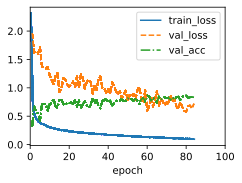

In [ ]:
trainer = d2l.Trainer(max_epochs=100, num_gpus=1)
data = d2l.FashionMNIST(batch_size=100, resize=(224, 224))
vgg11 = VGG11(lr=0.05)
vgg11.apply_init([next(iter(data.get_dataloader(True)))[0]], init_cnn)
trainer.fit(vgg11, data)

In [ ]:

def get_loss(model, data):
  model.train = False

  losses, access = [], []
  for (inputs, outputs) in data.val_dataloader():
    preds = model.forward(inputs.to(device))
    loss = model.loss(preds, outputs.to(device)).item()
    acc = model.accuracy(preds, outputs.to(device)).item()
    losses.append(loss)
    access.append(acc)

  return np.mean(np.array(losses)), np.mean(np.array(access))

test_data = d2l.FashionMNIST(batch_size=100, resize=(224, 224))
get_loss(vgg11, test_data)

(0.6386258074641228, 0.8325999808311463)